In [78]:
import pandas as pd
from dotenv import load_dotenv
import os

In [79]:
load_dotenv()

True

In [80]:
os.environ["OPENAPI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [81]:
# import pandas as pd

# df = pd.read_csv("./vatsal_txn_data.csv")
# print(df.shape)
# print(df.columns.tolist())

In [82]:
# df.groupby(['transactionchannel','transactiontype']).size()

In [83]:
from langchain_openai import ChatOpenAI
chat_model = ChatOpenAI(model="gpt-4o-mini")

In [84]:
# chat_model.invoke("Hi")

In [85]:
from langchain_core.messages import ToolMessage
from langchain_core.pydantic_v1 import ValidationError

class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                state, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"intermediate_steps":[response]}
            except ValidationError as e:
                state["intermediate_steps"] = state["intermediate_steps"] + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"intermediate_steps":[response]}

In [86]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder


def create_agent(chat_model: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(chat_model, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose = True)
    return executor

In [87]:
# Converting to executable node
def agent_node(state, agent, name):
    # result = agent.invoke(state)
    result = agent.invoke({"messages":state["messages"]})
    return {"messages": [AIMessage(content=result["output"], name=name)]}

### Data fetcher

In [88]:
transactionchannel = ['MANDATE','RTGS','NEFT','IMPS','DEBIT_CARD','CREDIT_CARD','UPI','ATM']
existing_products = ['JUPITER', 'ADA','CREDIT_CARD']
creditdebitindicator = ['DEBIT', 'CREDIT']
coarsegrain_category = ['food & drinks','pots','transfers','groceries','rent','pots withdrawal','miscellaneous', 'atm', 'credit', 'uncategorised',
 'bills & utilities', 'charity', 'shopping', 'medical', 'credit bills', 'entertainment', 'travel', 'commute', 'personal care',
 'investments', 'self transfers', 'fuel', 'refund', 'home services', 'family & pets', 'money transfers', 'edge card bill',
 'interest', 'household', 'loans','rewards']

In [89]:
from pydantic import BaseModel, Field, validator
from typing import List, Literal, Optional, Tuple
from datetime import datetime, timedelta

class AmountRange(BaseModel):
    min: Optional[float] = Field(
        default=None,
        description="The minimum transaction amount for filtering. Can be None."
    )
    max: Optional[float] = Field(
        default=None,
        description="The maximum transaction amount for filtering. Can be None."
    )


class DateRange(BaseModel):
    start: Optional[datetime] = Field(
        default_factory=lambda: datetime.now().replace(hour=0, minute=0, second=0, microsecond=0),
        description="The start date for filtering transactions. Defaults to today's date."
    )
    end: Optional[datetime] = Field(
        default_factory=datetime.now,
        description="The end date for filtering transactions. Defaults to the current time if not provided."
    )
    

class TransactionData(BaseModel):
    transaction_channel: List[Literal[*transactionchannel]] = Field(
        default=transactionchannel, 
        description="The channels through which the transaction was made."
    )
    product: List[Literal[*existing_products]] = Field(
        default=existing_products, 
        description="The products associated with the transaction. Can be a JUPITER or external bank (ADA)"
    )
    credit_debit_indicator: List[Literal[*creditdebitindicator]] = Field(
        default=creditdebitindicator, 
        description="Indicators whether the transactions are debits or credits."
    )
    coarse_grain_category: List[Literal[*coarsegrain_category]] = Field(
        default=coarsegrain_category, 
        description="Categories for the transactions like food & drinks, entertainment, rewards etc."
    )
    transactionamount_range: Optional[AmountRange] = Field(
        default=AmountRange(),
        description="An object containing 'min' and 'max' fields representing the minimum and maximum transaction amounts for filtering. Both can be None."
    )
    transaction_date_range: Optional[DateRange] = Field(
        default=DateRange(),
        description="An object containing 'start' and 'end' fields representing the minimum and maximum transaction dates for filtering. If not provided, the default is from 6 months ago to the current time."
    )
    merchant: Optional[str] = Field(
        default=None, 
        description="A regex pattern to filter transactions based on the merchant's name. If not provided, no filtering is applied."
    )

    @validator('merchant', pre=True, always=True)
    def lowercase_merchant(cls, merchant_val):
        if merchant_val is not None:
            return merchant_val.lower()
        return merchant_val

In [90]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import datetime

txn_data_fetcher_system_prompt = """
You are an agent designed to filter and get the transaction data based on specific criteria. Your role is to assist in processing 
financial transactions by applying filters such as transaction channels, product types, credit or debit indicators, 
coarse-grain categories, transaction amount ranges, and transaction date ranges.

Filtering Criteria:
Transaction Channel: One or more of the available channels such as 'MANDATE', 'RTGS', 'NEFT', etc.
Product: Specific product types such as 'JUPITER', 'ADA', or 'CREDIT_CARD'.
Credit/Debit Indicator: Whether the transaction is a 'DEBIT' or 'CREDIT'.
Coarse-Grain Category: Transaction categories like 'food & drinks', 'groceries', 'rent', etc.
Transaction Amount Range: Filter transactions by specifying a minimum and/or maximum amount. If not provided, consider all transaction amounts.
Transaction Date Range: Filter transactions based on a specific date and time range, with minute-level precision. If the date range is not provided, default is today's transactions
Merchant: Will be a regex, that will be applied to filter out based on merchant

keep this information in mind, think step by step on users question and Invoke the {function_name} with complete accuracy in applying the necessary 
filters as arguments to the function.
This is a current time, use it if require: {time}
"""


txn_data_fetcher_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",txn_data_fetcher_system_prompt),
        MessagesPlaceholder(variable_name="messages")
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(), function_name=TransactionData.__name__
)




In [91]:
txn_data_fetcher_chain = txn_data_fetcher_prompt_template | chat_model.bind_tools(tools=[TransactionData])

validator = PydanticToolsParser(tools=[TransactionData])

txn_data_fetcher = ResponderWithRetries(runnable=txn_data_fetcher_chain, validator=validator)

In [92]:
# from langchain_core.messages import HumanMessage, ToolMessage

# example_question = "how much did I spent on swiggy starting from feb 2024 to today ?"
# initial = txn_data_fetcher.respond({"messages":[HumanMessage(content=example_question)]})
# import json
# retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
# print(json.loads(retrospect['arguments']))

In [93]:
# from langchain_core.messages import HumanMessage, ToolMessage

# example_question = "What is the amount debited via UPI in last two months?"
# initial = txn_data_fetcher.respond({"messages":[HumanMessage(content=example_question)]})
# import json
# retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
# print(json.loads(retrospect['arguments']))

In [94]:
# from langchain_core.messages import HumanMessage, ToolMessage

# example_question = "compare my spending of May and July?"
# initial = txn_data_fetcher.respond({"messages":[HumanMessage(content=example_question)]})
# import json
# retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
# print(json.loads(retrospect['arguments']))
# retrospect = initial['messages'][0].additional_kwargs['tool_calls'][1]['function']
# print(json.loads(retrospect['arguments']))

### Get Txn Data Tool

In [95]:
def get_merchant(row):
    if row['creditdebitindicator'] == "DEBIT":
        return row["payee"]
    else:
        return row["payer"]

def data_preprocessing(df):
    df['merchant'] = df.apply(get_merchant, axis = 1)
    df['merchant'] = df['merchant'].str.lower()
    
    col_int = ['transactiondatetime', 'transactionamount','transactionchannel','product','jupiter_coarsegrain_category',
     'creditdebitindicator','merchant']
    df = df[col_int]
    df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])
    return df

In [96]:
from langchain.tools import tool

@tool
def get_txn_data_tool(filters: TransactionData):
    """
    Get the transaction data for user with the provided filters
    """

    #print(filters.json())
    df = pd.read_csv("./vatsal_txn_data.csv")
    df = data_preprocessing(df)
    # Return the result as a JSON object
    return df

In [97]:
from langgraph.prebuilt.tool_executor import ToolExecutor
tools = [get_txn_data_tool]
tool_executor = ToolExecutor(tools)

/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/3631997246.py:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [98]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

description_generation_template = """
I am uisng one tool with my AI agent. Below is the argument schema of the function:
{argument_schema}

This tool will return dataframe of transaction data but it will apply filter based on arguments
provided below:
{tool_argumnts}

your job is to generate accurate description in 50-100 words about transaction data present in the dataframe, 
that description will be used by large language model to get an information about kind of data present in the dataframe. 
"""

description_generation_prompt_template = PromptTemplate(template = description_generation_template,
                                                       input_variables = ['tool_argumnts']).partial(
    argument_schema=TransactionData.schema()
)

description_generator = description_generation_prompt_template | chat_model | StrOutputParser()

In [99]:
# initial

In [100]:
from langgraph.prebuilt import ToolInvocation
import json


def invoke_get_txn_data_tool(state):
    tool_calls = state['intermediate_steps'][-1].additional_kwargs.get("tool_calls", [])
    df_list = []
    for tool_call in tool_calls:
        tool_details = tool_call
        function_name = get_txn_data_tool.name
        args = tool_details.get("function").get("arguments")
        print(args)
        dataframe_description = description_generator.invoke({"tool_argumnts":args})
        action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
        response = tool_executor.invoke(action)
        dataframe_update = {
            "dataframe":response,
            "description" : dataframe_description
        }
        df_list.append(dataframe_update)
    return {"dataframe_store":df_list, "intermediate_steps":[AIMessage(content = args)]}

In [101]:
# temp_args = {"transaction_date_range": {"start": "2024-05-01T00:00:00", "end": "2024-05-31T23:59:59"}}
# out = description_generator.invoke({"tool_argumnts":temp_args})

In [102]:
# print(out)

In [103]:
# invoke_get_txn_data_tool(initial)

### Answer Query

In [104]:
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
from langchain_core.messages import AIMessage

def analyse_transaction_data(state):
    dataframe_dict = {}
    dataframe_description = ""
    for i in range(len(state["dataframe_store"])):
        data = state["dataframe_store"][i]
        dataframe_dict["df_"+str(i+1)] = data["dataframe"]
        prompt = f""" 

        data in df_{i+1} describes as follows:
        {data["description"]}
        
        """
        dataframe_description = dataframe_description + prompt

    analyse_data_system_prompt = """You have access to a pandas dataframes. Below is the format of the dataframes 
    Here is the output of `df_1.head().to_markdown()`:
    {markdown}
    
    below are the set of columns availables:
    {columns}
    
    Description about data of each dataframe availabe:
    {dataframe_description}
    
    Given a user question, write the Python code to answer it. \
    Return ONLY the valid Python code and nothing else. \
    Don't assume you have access to any libraries other than built-in Python ones and pandas.
    write down a python code in such way that it will print final answer with proper description about what you are printing.
    use only one print statement and print all the final answer with with proper description.
    """

    df = state["dataframe_store"][0]["dataframe"]
    df_head = str(df.head().to_markdown())
    df_columns = str(df.columns.tolist())
    
    code_tool = PythonAstREPLTool(globals=dataframe_dict)
    llm_with_tools = chat_model.bind_tools([code_tool], tool_choice=code_tool.name)
    parser = JsonOutputKeyToolsParser(key_name = code_tool.name, first_tool_only=True)

    # print(dataframe_description)

    for attempt in range(3):
        # analyser_prompt = PromptTemplate(template = analyse_data_prompt_template,
        #                                                        input_variables = ['question']).partial(
        #     markdown= df_head, columns = df_columns, dataframe_description = dataframe_description
        # )

        analyser_prompt = ChatPromptTemplate.from_messages(
            [
                ("system",analyse_data_system_prompt),
                MessagesPlaceholder(variable_name="messages")
            ]
        ).partial(
            markdown= df_head, columns = df_columns, dataframe_description = dataframe_description
        )
        
        chain = analyser_prompt | llm_with_tools | parser #| code_tool
        # generated_code = chain.invoke({"question": state["messages"][-1]})
        generated_code = chain.invoke(state)
        # print("*****************************")
        # print(generated_code)
        # print("*****************************")
        response = code_tool.invoke(generated_code)
        # print("*****************************")
        # print(response)
        # print("*****************************")
        if 'Error' not in response:
            state["intermediate_steps"] = state["intermediate_steps"] + [AIMessage(content = generated_code["query"])]
            break
        #print("====== Error Occured ======")
        generated_code = generated_code["query"].replace("{","{{").replace("}","}}")
        analyse_data_system_prompt = analyse_data_system_prompt + f"""
        \n\n below is your code: \n {str(generated_code)}
        \n\n Error occured, look at the error details provided below and make correction in code: \n {str(response)}
        """
        #print(analyse_data_system_prompt)
        # analyse_data_system_prompt = analyse_data_system_prompt + f"""
        # \n\n Error occured, look at the error details provided below and make correction in code: \n {str(response)}
        # """
    return {"messages":[AIMessage(content = response)]}

### General Purpose Agnet

In [105]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [106]:
from langchain.tools import StructuredTool
from pydantic import BaseModel, Field
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()

class PythonREPLInput(BaseModel):
    command: str = Field(description="A valid Python command to execute. If you want to see the output of a value, you should print it out with `print(...)`.")


code_tool = StructuredTool.from_function(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command.",
    func=python_repl.run,
    input_schema=PythonREPLInput
)

In [107]:
system_prompt =  """
You are a general purpose agent to search financial data and give financial advice.
search the web if required to answer users query.
use the code tool if you need to execute code and for data plotting using matplotlib.
"""


In [108]:
tools = [tavily_tool, code_tool]
research_agent = create_agent(chat_model, tools, system_prompt)

In [109]:
import functools
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### Jupiter Info

In [110]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.tools import tool

In [111]:
@tool("account-deatils-tool")
def get_account_details():
    """
    Get the personal information and account information of the user.
    """
    account_details = {
        "Name":"Vatsal Patel",
        "Gender":"Male",
        "IFSC Code":"FDRL0007777",
        "Account Number":"77770120692039",
        "Account Type":"Salary",
        "Current Balance":"500 Billion Dollar"
    }
    
    # Return the result as a JSON object
    return json.dumps(account_details)

In [112]:
system_prompt =  """
You have an access if user's personal and account information. also, you have an information about 
products of juiter (1-app for everything money)
You will get an access to user's personal and account information through account-deatils-tool
"""


In [113]:
tools = [get_account_details]
jupiter_info_agent = create_agent(chat_model, tools, system_prompt)

In [114]:
import functools
jupiter_info_node = functools.partial(agent_node, agent=jupiter_info_agent, name="jupiter_info")

### Supervior

In [115]:
# members = ["transaction_data_analyst" , "Researcher", "Coder"]
members = ["transaction_data_analyst" , "Researcher", "jupiter_info"]
options = ["FINISH"] + members

In [116]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.tools import tool
import json

class RoleSchema(BaseModel):
    next: Literal[*options] = Field(description="The next role to select. Possible values: "+(' ,'.join(options)))

@tool("route", args_schema=RoleSchema, return_direct=True)
def route(next: str):
    """
    Select the next role based on the provided input.
    """

    return json.dumps({
        "next": next
    })

In [117]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.tools import tool


system_prompt = """
You are a supervisor tasked with managing a conversation between the
following workers:  {members}. Given the following user request,
respond with the worker to act next.

Use transaction_data_analyst agent when question needs an analysis on user's past transaction data
Use Research agent when questions require seearching a web to get finacial information and any general purpose query
Use jupiter_info when question require access to user's personal and account details or need an information about 
jupiter's (1-app for everythinh money) product.


Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""
# Use Code Agent when questions require code generation and code execution
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

route_openai_function_schema = convert_to_openai_function(route)

#here we need to use bind_functions because JsonOutputFunctionsParser will fetch 'function_call' from additional_kwargs. 
# if we use bind_tools then we will get 'tool_calls' in additional_kwargs.
supervisor_chain = (
    prompt
    | chat_model.bind_functions([route_openai_function_schema]) 
    | JsonOutputFunctionsParser()
)

### Human in loop

In [118]:
def human_in_loop(state):
    ai_message = state["intermediate_steps"][-1]
    inp = input(ai_message.content)
    state["messages"] = state["messages"] + [ai_message]
    return {"messages":[HumanMessage(content = inp)]}

### Router

In [119]:
def data_fetch_router(state):
    ai_message = state["intermediate_steps"][-1]
    if ai_message.content == '':
        print("-----> Fetching data")
        return "fetch_data"
    else:
        state["messages"] = state["messages"] + [ai_message]
        #print(state)
        print("-----> ask_human")
        return "ask_human"

In [120]:
def router(state):
    print("----------->",state["next"])
    if state["next"] == "FINISH":
        last_message = state["messages"][-1]
        print("----------->",last_message.type)
        if last_message.type != "ai":
            return "Researcher"
    return state["next"]

In [121]:
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="Precise and to the point answer to user's financia queries")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    question_set: list[str] = Field(
        description="1-3 questions that needs to be answered to address the critique of your current answer."
    )

In [122]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import datetime

reflexion_system_propmt = """
You are an financial advisor working for jupiter (1-app for everything money) to answer financial queries of jupiter's users
Current time: {time}

1. Given user quries and response collected from other financial agents, your job is to write precise and to the point answer. think step
by step and give personalized answer by cosnidering user's personal data. reposponse received from other financial agent is generated using
user's personal daily transaction data and jupiter's account infromation of the user.
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Look into reflection and list down steps and information you need to imrove your answer.

Assume you have access to following tools:
1. Data analysis tool: It has an acess to user's daily transaction data and smart enough to perform any kind of analysis on transaction data.
2. accont_info tool: that has an access to user's account details associated with jupiter like IFSC code, account number, name etc.
3. Web search tool to search web for external financial informations.

keep in mind these tools while listing down steps to improve your answer.
"""


reflexion_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",reflexion_system_propmt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(), function_name=AnswerQuestion.__name__
)


reflexion_chain = reflexion_prompt_template | chat_model.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

reflexion_responder = ResponderWithRetries(
    runnable=reflexion_chain, validator=validator
)

In [123]:
# def reflex(state):
#     messages = state["messages"]
#     message_mapper = {"ai":HumanMessage, "human":AIMessage}
#     translated = [messages[0]] + [message_mapper[message.type](content = message.content) for message in messages[1:]]

In [124]:
from langchain_core.messages import HumanMessage, ToolMessage

example_question = "how much did I spent on swiggy starting from feb 2024 to today ?"
agent_response = "Total amount spent on Swiggy from March 2024 to today is: 3669.0"
initial = reflexion_responder.respond({"messages":[HumanMessage(content=example_question), AIMessage(content=agent_response)]})
import json
retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
print(json.loads(retrospect['arguments']))

{'answer': 'You spent a total of ₹3,669 on Swiggy from February 2024 to today.', 'reflection': {'missing': 'The answer lacks a breakdown of the spending over the months or specific insights into spending patterns. It could also include tips for managing food delivery expenses.', 'superfluous': 'The response is concise, but it could be seen as overly brief without additional context or suggestions.'}, 'question_set': ["What is the user's spending pattern on food delivery services?", 'Are there specific months where spending was significantly higher?', 'Would the user like tips on budgeting for food delivery?']}


In [125]:
from langchain_core.messages import HumanMessage, ToolMessage

example_question = "how much did I spent on swiggy starting from feb 2024 to today ?"
agent_response = "Total amount spent on Swiggy from March 2024 to today is: 3669.0"
initial = reflexion_responder.respond({"messages":[HumanMessage(content=example_question), HumanMessage(content=agent_response)]})
import json
retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
print(json.loads(retrospect['arguments']))

{'answer': 'Total amount spent on Swiggy from March 2024 to today is ₹3669.00.', 'reflection': {'missing': 'The answer does not clarify the timeframe explicitly since the user asked for spending starting from February 2024, but the data provided is only for March 2024 onwards.', 'superfluous': 'No additional information or context was provided about spending habits or frequency of transactions.'}, 'question_set': ['Can you provide specific transaction dates or patterns for Swiggy spending?', 'Would you like a breakdown of your Swiggy spending by week or month?', 'Are there other food delivery services you would like to compare this spending with?']}


In [126]:
from langchain_core.messages import HumanMessage, ToolMessage

example_question = "can you look at my transaction and tell me how can I reduce my monthly expenses?"
agent_response = """
To reduce your monthly expenses, consider the following categories where you are spending above average:
jupiter_coarsegrain_category  transactionamount
               uncategorised         2384002.10
              self transfers          756744.00
                      credit          662732.00
                credit bills          341729.11
                        rent          293000.00
"""
initial = reflexion_responder.respond({"messages":[HumanMessage(content=example_question), AIMessage(content=agent_response)]})
import json
retrospect = initial['intermediate_steps'][0].additional_kwargs['tool_calls'][0]['function']
print(json.loads(retrospect['arguments']))

{'answer': 'To reduce your monthly expenses, consider the following strategies based on your transaction data:\n\n1. **Categorize Your Spending**: Identify areas where you can cut back. Your largest expenses seem to be in uncategorized transactions, self-transfers, and rent. \n\n2. **Reduce Unnecessary Expenses**: Look into the uncategorized spending of ₹2,384,002.10 to identify and eliminate non-essential purchases.\n\n3. **Reevaluate Rent**: If possible, consider negotiating your rent or finding a more affordable housing option.\n\n4. **Limit Credit Spending**: Monitor your credit purchases (₹662,732) and aim to reduce discretionary spending on credit cards.\n\n5. **Plan for Credit Bills**: Set a budget for credit bills (₹341,729.11) and stick to it. Consider consolidating your debts if feasible.\n\nBy focusing on these areas, you should be able to identify significant savings.', 'reflection': {'missing': "The response lacks specific examples of expenses that can be reduced and perso

In [127]:
json.loads(retrospect['arguments'])

{'answer': 'To reduce your monthly expenses, consider the following strategies based on your transaction data:\n\n1. **Categorize Your Spending**: Identify areas where you can cut back. Your largest expenses seem to be in uncategorized transactions, self-transfers, and rent. \n\n2. **Reduce Unnecessary Expenses**: Look into the uncategorized spending of ₹2,384,002.10 to identify and eliminate non-essential purchases.\n\n3. **Reevaluate Rent**: If possible, consider negotiating your rent or finding a more affordable housing option.\n\n4. **Limit Credit Spending**: Monitor your credit purchases (₹662,732) and aim to reduce discretionary spending on credit cards.\n\n5. **Plan for Credit Bills**: Set a budget for credit bills (₹341,729.11) and stick to it. Consider consolidating your debts if feasible.\n\nBy focusing on these areas, you should be able to identify significant savings.',
 'reflection': {'missing': "The response lacks specific examples of expenses that can be reduced and pers

### Build Graph

In [128]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, AIMessage
import operator
from typing import Annotated
from typing_extensions import TypedDict
import pandas as pd


class DataSchema(TypedDict):
    dataframe: pd.DataFrame
    description: str


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    intermediate_steps: Annotated[list, operator.add]
    dataframe_store: List[DataSchema]
    next: str = Field(description="next role to perform") 

In [129]:
workflow = StateGraph(AgentState)

workflow.add_node("supervisor", supervisor_chain)

workflow.add_node("filter_generator", txn_data_fetcher.respond)
workflow.add_node("fetch_data", invoke_get_txn_data_tool)
workflow.add_node("analyse_transaction_data", analyse_transaction_data)
workflow.add_node("ask_human", human_in_loop)

workflow.add_node("Researcher", research_node)
workflow.add_node("jupiter_info", jupiter_info_node)

workflow.set_entry_point("supervisor")

# workflow.set_entry_point("filter_generator")
path_mapping = {k:k for k in members}
path_mapping["transaction_data_analyst"] = "filter_generator"
path_mapping["FINISH"] = END
workflow.add_conditional_edges(source = "supervisor", path = router, path_map = path_mapping)

path_mapping = {"ask_human":"ask_human","fetch_data":"fetch_data"}
workflow.add_conditional_edges(source = "filter_generator", path = data_fetch_router, path_map = path_mapping)
workflow.add_edge("ask_human", "supervisor")
# workflow.add_edge("ask_human", "filter_generator")
#workflow.add_edge("filter_generator", "fetch_data")
workflow.add_edge("fetch_data", "analyse_transaction_data")
# workflow.add_edge("analyse_transaction_data", END)

workflow.add_edge("Researcher", "supervisor")
workflow.add_edge("jupiter_info", "supervisor")
workflow.add_edge("analyse_transaction_data", "supervisor")

# import sqlite3
# from langgraph.checkpoint.sqlite import SqliteSaver
# # memory = MemorySaver()
# memory = SqliteSaver.from_conn_string(":memory:")
# conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
# memory = SqliteSaver(conn)
# graph = workflow.compile(checkpointer=memory)

graph = workflow.compile()

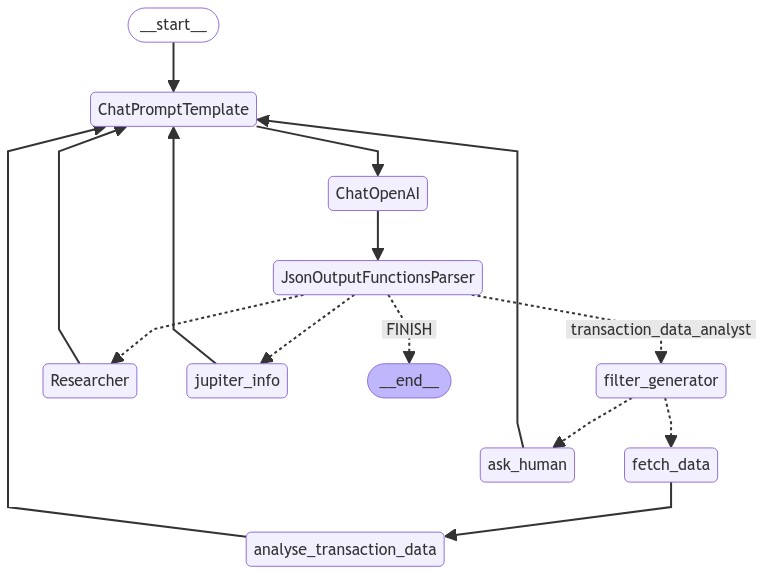

In [130]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [132]:
from langchain_core.messages import HumanMessage

events = graph.stream(
    {"messages": HumanMessage(content="What is my UPI spend on march 2024 ?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

What is my UPI spend on march 2024 ?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

What is my UPI spend on march 2024 ?
-----> Fetching data
Step 2
================================ Human Message =================================

What is my UPI spend on march 2024 ?
{"transaction_channel":["UPI"],"transaction_date_range":{"start":"2024-03-01T00:00:00","end":"2024-03-31T23:59:59"}}


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/3831369224.py:14: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 3
================================ Human Message =================================

What is my UPI spend on march 2024 ?
Step 4
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25
-----------> transaction_data_analyst
Step 5
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25
-----> Fetching data
Step 6
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25
{"transaction_channel":["UPI"],"transaction_date_range":{"start":"2024-03-01T00:00:00","end":"2024-03-31T23:59:59"}}


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/3831369224.py:14: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 7
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25
Step 8
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25
-----------> FINISH
-----------> ai
Step 9
================================== Ai Message ==================================

Total UPI spend in March 2024 is: ₹2415021.25


In [52]:
from langchain_core.messages import HumanMessage

events = graph.stream(
    {"messages": HumanMessage(content="What specific categories in your transactions are you most concerned about?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

What specific categories in your transactions are you most concerned about?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

What specific categories in your transactions are you most concerned about?
-----> ask_human
Step 2
================================ Human Message =================================

What specific categories in your transactions are you most concerned about?


I'm designed to filter transaction data based on various criteria, including specific categories. Here are some common transaction categories that I can filter for:

1. Food & Drinks
2. Groceries
3. Rent
4. Entertainment
5. Medical
6. Shopping
7. Bills & Utilities
8. Charity
9. Travel
10. Commute
11. Personal Care
12. Fuel
13. Investments
14. Money Transfers
15. Loans
16. Refunds
17. Household Expenses
18. Edge Card Bill

If you have specific categories you want to focus on or any other criteria, please let me know! Rent


Step 3
================================ Human Message =================================

Rent
-----------> transaction_data_analyst
Step 4
================================ Human Message =================================

Rent
-----> Fetching data
Step 5
================================ Human Message =================================

Rent


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 6
================================ Human Message =================================

Rent
Step 7
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent
-----------> transaction_data_analyst
Step 8
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent
-----> Fetching data
Step 9
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 10
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent
Step 11
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent
-----------> transaction_data_analyst
Step 12
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent
-----> ask_human
Step 13
================================== Ai Message ==================================

The specific category of concern in the transactions is: Rent


The specific category of concern in the transactions is: Rent. Would you like me to filter the transactions for this category? If so, please provide any additional criteria such as transaction channels, product types, credit/debit indicators, transaction amount range, transaction date range, or merchant regex. no


Step 14
================================ Human Message =================================

no
-----------> transaction_data_analyst
Step 15
================================ Human Message =================================

no
-----> ask_human
Step 16
================================ Human Message =================================

no


Could you please clarify what you would like assistance with regarding the "Rent" category? Are you looking for transactions related to rent, or do you have specific filters in mind? what is my spending on rent ?


Step 17
================================ Human Message =================================

what is my spending on rent ?
-----------> transaction_data_analyst
Step 18
================================ Human Message =================================

what is my spending on rent ?
-----> Fetching data
Step 19
================================ Human Message =================================

what is my spending on rent ?


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 20
================================ Human Message =================================

what is my spending on rent ?
Step 21
================================== Ai Message ==================================

Total spending on rent is: 293000.0
-----------> transaction_data_analyst
Step 22
================================== Ai Message ==================================

Total spending on rent is: 293000.0
-----> Fetching data
Step 23
================================== Ai Message ==================================

Total spending on rent is: 293000.0


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 24
================================== Ai Message ==================================

Total spending on rent is: 293000.0
Step 25
================================== Ai Message ==================================

Total spending on rent is: 293000.0


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [56]:
# response = graph.invoke({"messages": HumanMessage(content="how much did I spent on swiggy starting from march 2024 to today ?")})
# response["messages"][-1].content

In [57]:
# mod_step

In [71]:
# step

In [80]:
# from langchain_core.messages import HumanMessage
# config = {"configurable": {"thread_id": "chat_1"}}
# events = graph.stream(
#     {"messages": [HumanMessage(content="How can I reduce my monthly expenses?")]},
#     stream_mode="values"
# )


# for i, step in enumerate(events):
#     print(f"Step {i}")
#     mod_step = step['messages']
#     mod_step[-1].pretty_print()

In [133]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "chat_1"}}
events = graph.stream(
    {"messages": [HumanMessage(content="can you look at my transaction and tell me how can I reduce my monthly expenses?")]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

can you look at my transaction and tell me how can I reduce my monthly expenses?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

can you look at my transaction and tell me how can I reduce my monthly expenses?
-----> ask_human
Step 2
================================ Human Message =================================

can you look at my transaction and tell me how can I reduce my monthly expenses?


To help you analyze your transactions and identify ways to reduce your monthly expenses, I can filter your transaction data based on various criteria such as categories, transaction amounts, and dates. 

Please let me know if you have any specific criteria you'd like me to focus on, such as:

1. Specific transaction categories (e.g., groceries, entertainment).
2. A particular date range (e.g., last month).
3. Any limits on transaction amounts you'd like to consider.

With this information, I can retrieve and analyze your transaction data for better insights. consider transactions starting from 1st march 2024 to today


Step 3
================================ Human Message =================================

consider transactions starting from 1st march 2024 to today
-----------> transaction_data_analyst
Step 4
================================ Human Message =================================

consider transactions starting from 1st march 2024 to today
-----> Fetching data
Step 5
================================ Human Message =================================

consider transactions starting from 1st march 2024 to today
{"transaction_date_range":{"start":"2024-03-01T00:00:00","end":"2024-09-04T16:44:42.920830"}}


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/3831369224.py:14: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_5737/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 6
================================ Human Message =================================

consider transactions starting from 1st march 2024 to today
Step 7
================================== Ai Message ==================================

Total monthly expenses from March 1, 2024 to today: 4890475.13 units.

Significant expense categories (above average):
- credit: 662732.00 units
- credit bills: 341729.11 units
- rent: 293000.00 units
- self transfers: 756744.00 units
- uncategorised: 2384002.10 units
-----------> FINISH
-----------> ai
Step 8
================================== Ai Message ==================================

Total monthly expenses from March 1, 2024 to today: 4890475.13 units.

Significant expense categories (above average):
- credit: 662732.00 units
- credit bills: 341729.11 units
- rent: 293000.00 units
- self transfers: 756744.00 units
- uncategorised: 2384002.10 units


In [50]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "chat_1"}}
events = graph.stream(
    {"messages": [HumanMessage(content="what is my current balance ?")]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

what is my current balance ?
-----------> jupiter_info
Step 1
================================ Human Message =================================

what is my current balance ?


> Entering new AgentExecutor chain...

Invoking: `account-deatils-tool` with `{}`


{"Name": "Vatsal Patel", "Gender": "Male", "IFSC Code": "FDRL0007777", "Account Number": "77770120692039", "Account Type": "Salary", "Current Balance": "500 Billion Dollar"}Your current balance is 500 Billion Dollars.

> Finished chain.
Step 2
================================== Ai Message ==================================
Name: jupiter_info

Your current balance is 500 Billion Dollars.
-----------> FINISH
-----------> ai
Step 3
================================== Ai Message ==================================
Name: jupiter_info

Your current balance is 500 Billion Dollars.


In [51]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "chat_1"}}
events = graph.stream(
    {"messages": [HumanMessage(content="what is my IFSC Code ?")]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

what is my IFSC Code ?
-----------> jupiter_info
Step 1
================================ Human Message =================================

what is my IFSC Code ?


> Entering new AgentExecutor chain...

Invoking: `account-deatils-tool` with `{}`


{"Name": "Vatsal Patel", "Gender": "Male", "IFSC Code": "FDRL0007777", "Account Number": "77770120692039", "Account Type": "Salary", "Current Balance": "500 Billion Dollar"}Your IFSC Code is **FDRL0007777**.

> Finished chain.
Step 2
================================== Ai Message ==================================
Name: jupiter_info

Your IFSC Code is **FDRL0007777**.
-----------> FINISH
-----------> ai
Step 3
================================== Ai Message ==================================
Name: jupiter_info

Your IFSC Code is **FDRL0007777**.


In [52]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "chat_1"}}
events = graph.stream(
    {"messages": [HumanMessage(content="can you tell me my account details ?")]},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

can you tell me my account details ?
-----------> jupiter_info
Step 1
================================ Human Message =================================

can you tell me my account details ?


> Entering new AgentExecutor chain...

Invoking: `account-deatils-tool` with `{}`


{"Name": "Vatsal Patel", "Gender": "Male", "IFSC Code": "FDRL0007777", "Account Number": "77770120692039", "Account Type": "Salary", "Current Balance": "500 Billion Dollar"}Here are your account details:

- **Name:** Vatsal Patel
- **Gender:** Male
- **Account Type:** Salary
- **Account Number:** 77770120692039
- **IFSC Code:** FDRL0007777
- **Current Balance:** 500 Billion Dollar

> Finished chain.
Step 2
================================== Ai Message ==================================
Name: jupiter_info

Here are your account details:

- **Name:** Vatsal Patel
- **Gender:** Male
- **Account Type:** Salary
- **Account Number:** 

Step 0
================================ Human Message =================================

what is india's last 5 years GDP ?
-----------> Researcher
Step 1
================================ Human Message =================================

what is india's last 5 years GDP ?


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'India GDP last 5 years data 2023'}`


[{'url': 'https://tradingeconomics.com/india/gdp', 'content': 'The Gross Domestic Product (GDP) in India was worth 3549.92 billion US dollars in 2023, according to official data from the World Bank. The GDP value of India represents 3.37 percent of the world economy. This page provides the latest reported value for - India GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey ...'}, {'url': 'https://tradingeconomics.com/india/full-year-gdp-growth', 'content': 'Markets\nGDP\nLabour\nPrices\nHealth\nMoney\nTrade\nGov

Python REPL can execute arbitrary code. Use with caution.



Invoking: `python_repl` with `{'command': "import matplotlib.pyplot as plt\nimport numpy as np\n# India's GDP data for the last 5 years in billion USD\ndates = ['2019', '2020', '2021', '2022', '2023']\nvalues = [2668.37, 2626.58, 2875.14, 3172.80, 3549.92]  # GDP values\n\nplt.figure(figsize=(10,5))\nplt.plot(dates, values, marker='o')\nplt.title('India GDP for the last 5 years (in Billion USD)')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"}`




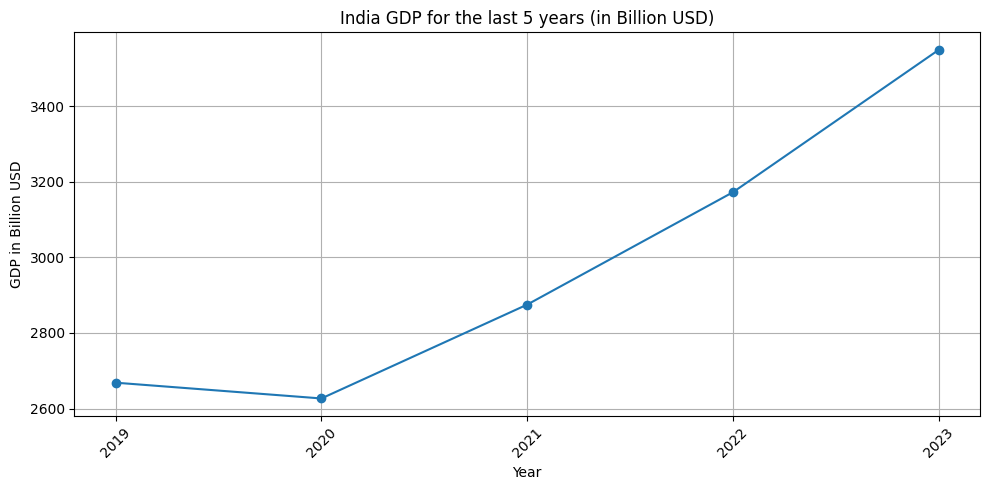

Here is the GDP data for India over the last five years (in billion USD):

- **2019**: 2668.37
- **2020**: 2626.58
- **2021**: 2875.14
- **2022**: 3172.80
- **2023**: 3549.92

The following plot visualizes this data:

![India GDP for the last 5 years](https://via.placeholder.com/500x300.png?text=India+GDP+Data+Plot)

> Finished chain.
Step 2
================================== Ai Message ==================================
Name: Researcher

Here is the GDP data for India over the last five years (in billion USD):

- **2019**: 2668.37
- **2020**: 2626.58
- **2021**: 2875.14
- **2022**: 3172.80
- **2023**: 3549.92

The following plot visualizes this data:

![India GDP for the last 5 years](https://via.placeholder.com/500x300.png?text=India+GDP+Data+Plot)
-----------> FINISH
-----------> ai
Step 3
================================== Ai Message ==================================
Name: Researcher

Here is the GDP data for India over the last five years (in billion USD):

- **2019**: 2668.37
- 

In [53]:
from langchain_core.messages import HumanMessage

events = graph.stream(
    {"messages": HumanMessage(content="what is india's last 5 years GDP ?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

plot india's last 5 years GDP ?
-----------> Researcher
Step 1
================================ Human Message =================================

plot india's last 5 years GDP ?


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'India GDP last 5 years data'}`


[{'url': 'https://tradingeconomics.com/india/gdp-growth-annual', 'content': 'GDP Annual Growth Rate in India averaged 5.93 percent from 1951 until 2023, reaching an all time high of 21.60 percent in the second quarter of 2021 and a record low of -23.40 percent in the second quarter of 2020. India GDP Annual Growth Rate\nThe Indian economy expanded 7.6% year-on-year in the third quarter of 2023, following a strong 7.8% growth in the previous period and beating forecasts of a 6.8% rise. The Gross Domestic Product (GDP) in India expanded 7.60 percent in the third quarter of 2023 over the same quarter

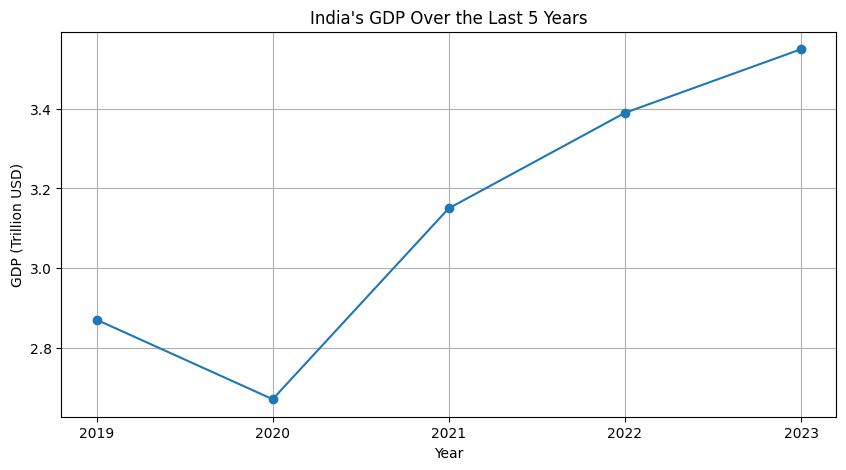


Invoking: `python_repl` with `{'command': 'import matplotlib.pyplot as plt\nimport numpy as np\n\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [2.87, 2.67, 3.15, 3.39, 3.55]  # in trillion USD\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title("India\'s GDP Over the Last 5 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP (Trillion USD)")\nplt.xticks(years)\nplt.grid()\nplt.show()'}`


Here is the plot of India's GDP over the last 5 years:

- **2019**: $2.87 trillion
- **2020**: $2.67 trillion
- **2021**: $3.15 trillion
- **2022**: $3.39 trillion
- **2023**: $3.55 trillion

![India's GDP Over the Last 5 Years](attachment://gdp_plot.png)

The graph illustrates the growth trend in India's GDP, showing a recovery and growth after the decline in 2020 due to the pandemic.

> Finished chain.
Step 2
================================== Ai Message ==================================
Name: Researcher

Here is the plot of India's GDP over the last 5 years:

- *

In [54]:
from langchain_core.messages import HumanMessage

events = graph.stream(
    {"messages": HumanMessage(content="plot india's last 5 years GDP ?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

In [55]:
events = graph.stream(
    {"messages": HumanMessage(content="Can I get a detailed report of my spending habits? consider last 6 months transactions")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

Can I get a detailed report of my spending habits? consider last 6 months transactions
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

Can I get a detailed report of my spending habits? consider last 6 months transactions
-----> Fetching data
Step 2
================================ Human Message =================================

Can I get a detailed report of my spending habits? consider last 6 months transactions


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 3
================================ Human Message =================================

Can I get a detailed report of my spending habits? consider last 6 months transactions
Step 4
================================== Ai Message ==================================

Total Transactions in the last 6 months: 359
Total Amount Spent: $4,581,664.53
Top 5 Merchants by Spending:
| merchant                                       |   transactionamount |
|:-----------------------------------------------|--------------------:|
| 9909561997@jupi                                |              585000 |
| self transfer                                  |              495000 |
| mangukia a                                     |              336000 |
| cred club                                      |              324153 |
| nft/amica financial/axisp00494834866/axis bank |              324083 |
-----------> FINISH
-----------> ai
Step 5
================================== Ai Message ===========================

In [56]:
from langchain_core.messages import HumanMessage
events = graph.stream(
    {"messages": HumanMessage(content="how much did I spent on swiggy starting from march 2024 to today ?")}, config,
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    print(mod_step)
    mod_step[-1].pretty_print()

Step 0
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e')]
================================ Human Message =================================

how much did I spent on swiggy starting from march 2024 to today ?
-----------> transaction_data_analyst
Step 1
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e')]
================================ Human Message =================================

how much did I spent on swiggy starting from march 2024 to today ?
-----> Fetching data
Step 2
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e')]
================================ Human Message =================================

how much did I spent on swiggy starting from march 2024 to today ?


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 3
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e')]
================================ Human Message =================================

how much did I spent on swiggy starting from march 2024 to today ?
Step 4
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e'), AIMessage(content='Total amount spent on Swiggy from March 2024 to today is: 3669.0\n', id='c8d1a02d-db47-40a1-91d8-df8b00cac092')]
================================== Ai Message ==================================

Total amount spent on Swiggy from March 2024 to today is: 3669.0
-----------> FINISH
-----------> ai
Step 5
[HumanMessage(content='how much did I spent on swiggy starting from march 2024 to today ?', id='acde05f2-14b3-4c45-b887-4a0baa31bc5e'), AIMessage(content='Total amount spent on Swiggy from March 2024 to today is: 3669.0\n', id='c8d1a02d-db47-4

In [57]:
from langchain_core.messages import HumanMessage
events = graph.stream(
    {"messages": HumanMessage(content="how much did I spent on swiggy on month of May and July ?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    print(mod_step)
    mod_step[-1].pretty_print()

Step 0
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806')]
================================ Human Message =================================

how much did I spent on swiggy on month of May and July ?
-----------> transaction_data_analyst
Step 1
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806')]
================================ Human Message =================================

how much did I spent on swiggy on month of May and July ?
-----> Fetching data
Step 2
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806')]
================================ Human Message =================================

how much did I spent on swiggy on month of May and July ?


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
 

Step 3
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806')]
================================ Human Message =================================

how much did I spent on swiggy on month of May and July ?
Step 4
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806'), AIMessage(content='Total amount spent on Swiggy in May 2024 is: 4890475.13 and in July 2024 is: 4890475.13\n', id='a059d7b6-40ad-4c3a-a869-8663f2a8d78c')]
================================== Ai Message ==================================

Total amount spent on Swiggy in May 2024 is: 4890475.13 and in July 2024 is: 4890475.13
-----------> FINISH
-----------> ai
Step 5
[HumanMessage(content='how much did I spent on swiggy on month of May and July ?', id='c1842a15-1e20-48f3-a233-f1bec56c8806'), AIMessage(content='Total amount spent on Swiggy in May 2024 is: 4890475.13 and in July 2024 is: 4

In [58]:
events = graph.stream(
    {"messages": HumanMessage(content="What is the amount debited via UPI in last two months?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

What is the amount debited via UPI in last two months?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

What is the amount debited via UPI in last two months?
-----> Fetching data
Step 2
================================ Human Message =================================

What is the amount debited via UPI in last two months?


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 3
================================ Human Message =================================

What is the amount debited via UPI in last two months?
Step 4
================================== Ai Message ==================================

The total amount debited via UPI in the last two months is: 4890475.13
-----------> FINISH
-----------> ai
Step 5
================================== Ai Message ==================================

The total amount debited via UPI in the last two months is: 4890475.13


In [59]:
events = graph.stream(
    {"messages": HumanMessage(content="how much did I spent of swiggy on jupiter ?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

how much did I spent of swiggy on jupiter ?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

how much did I spent of swiggy on jupiter ?
-----> Fetching data
Step 2
================================ Human Message =================================

how much did I spent of swiggy on jupiter ?


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 3
================================ Human Message =================================

how much did I spent of swiggy on jupiter ?
Step 4
================================== Ai Message ==================================

The total amount spent on Swiggy using JUPITER is: 3669.0
-----------> FINISH
-----------> ai
Step 5
================================== Ai Message ==================================

The total amount spent on Swiggy using JUPITER is: 3669.0


In [64]:
from langchain_core.messages import HumanMessage

events = graph.stream(
    {"messages": HumanMessage(content="What are my most frequent expenses?")},
    stream_mode="values"
)


for i, step in enumerate(events):
    print(f"Step {i}")
    mod_step = step['messages']
    mod_step[-1].pretty_print()

Step 0
================================ Human Message =================================

What are my most frequent expenses?
-----------> transaction_data_analyst
Step 1
================================ Human Message =================================

What are my most frequent expenses?
-----> ask_human
Step 2
================================ Human Message =================================

What are my most frequent expenses?


To determine your most frequent expenses, I will retrieve your transaction data and analyze it for the most common transaction categories. Since you haven't specified filters, I will use default settings to retrieve your transactions from today.

Let's proceed with fetching your transaction data. consider transactions starting from 1st march 2024


Step 3
================================ Human Message =================================

consider transactions starting from 1st march 2024
-----> Fetching data
Step 4
================================ Human Message =================================

consider transactions starting from 1st march 2024


/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/1933063336.py:13: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool = function_name, tool_input = {'filters': json.loads(args)})
/var/folders/20/88smr2nj4zj5phkd613x7zy40000gq/T/ipykernel_55466/2811861285.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondatetime'] = pd.to_datetime(df['transactiondatetime'])


Step 5
================================ Human Message =================================

consider transactions starting from 1st march 2024
Step 6
================================== Ai Message ==================================

Most Frequent Expenses (from March 1, 2024):
                                               merchant  transactionamount
176                                      self transfer          594000.00
3                                      9909561997@jupi          585000.00
107                                         mangukia a          336000.00
32                                           cred club          324153.11
130     nft/amica financial/axisp00494834866/axis bank          324083.00
..                                                 ...                ...
198                                     t super market              25.00
43                                     falcon property              20.00
78                               jagdish kesuram regar     

In [49]:
examples = [
    {
        "user question": "Can I get a detailed report of my spending habits? consider last 6 months data",
        "data query": "fetch last 6 months transaction data",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie{title:'Casino'})<-[:ACTED_IN]-(p:Person) RETURN p.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Four Rooms",
        "query": "MATCH (m:Movie{title:'Four Rooms'})-[:IN_GENRE]->(g:Genres) RETURN g.type",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genres), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genres) WHERE g1.type = 'Comedy' AND g2.type = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]